## Implementing the A * Algorithm


In [42]:
import numpy as np

### Defining the location/position class for a node

In [43]:
class Position:
    w = 1
    def __init__(self, row, col, pred, goal):
        self.row = row
        self.col = col
        self.predecessor = pred
        self.goal = goal
        self.f = 0 #for all admissible points in the raster map
        self.fp = 0 #for all inadmissible points in the raster map
        self.g = 0 #our cost function
        self.h = 0 #our heuristic function

    '''Establish equality criterion between two positions'''
    def __eq__(self, pos2):
        if self.row == pos2.row and self.col == pos2.col:
            return True
        else:
            return False

    '''String representation of the position'''
    def __str__(self):
        return 'Row: {}, Col: {}, fp({}) = g({}) + {}h'.format(self.row,self.col,self.fp,self.g,self.h)

    '''Check if we have reached the goal position'''
    def is_goal(self):
        assert self.goal is not None
        if self.row == self.goal.row and self.col == self.goal.col:
            return True
        else:
            return False

    '''Calculate the hueristic from the heuristic function'''
    def calc_h(self):
        assert self.goal is not None
        self.h = abs(self.row - self.goal.row) + abs(self.col - self.goal.col)

    '''Calculate the cost from the cost function'''
    def calc_g(self):
        assert self.predecessor is not None
        self.g = self.predecessor.g +1

    '''Determine if a position is admissible or inadmissible'''
    def calc_f(self):
        self.f = self.g + self.h
        self.fp = self.g + self.w + self.h
        
    '''Calculate all costs'''
    def costs(self):
        self.calc_h()
        self.calc_g()
        self.calc_f()



### Defining the boad class as a 2D numpy array (will also hold our raster map)

In [44]:
from numpy.random import choice

class Board:
    board = []
    def __init__(self, rows, columns, blocks):
        self.rows = rows
        self.cols = columns
        self.blocks = blocks

    '''Print the board'''
    def __str__(self):
        result = str()
        for i in range(self.rows):
            for j in range(self.cols):
                if self.board[i,j] == 0:
                    result +='- '
                elif self.board[i,j] == 1:
                    result += '* '
                else:
                    result += 'o '
            result += '\n'
        return result


    '''Initialize the board with random obstacles'''
    def initialize(self):
        res =  np.zeros((self.rows,self.cols))
        for i in range(self.blocks):
            x = choice(range(self.rows),1)
            y = choice(range(self.cols),1)
            if x+y != 0 and x+y != self.rows+self.cols: #if we have not selected the row and column
                res[x,y] = 1
        self.board = res

    '''Initialize the board with a specific raster map'''
    def initialize_spec(self):
        res =  np.zeros((self.rows,self.cols))
        map = {4:[14,15,16,17], 5:[2,3,4,5,14], 6:[2,3,4,5,14,15,16,17],7:[4,5,8,9,10,11,12],8:[4,5,8,9,10,11,12],9:[4,5,8,9,10,11,12],10:[2,3,4,5,14,15,16,17],11:[14,15,16,17]}
        for row in map:
            for col in map[row]:
                res[row,col] = 1
        self.board = res

### Define function to get the successors of a particular node

In [45]:
def gen_successors(node, board):
    successors = list()

    #check successors above the node
    if node.row != 0:
        if board.board[node.row-1,node.col] != 1: #Is the node above a barrier
           successors.append(Position(node.row+1,node.col,node,node.goal))

    #check successors below the node
    if node.row != board.rows - 1:
        if board.board[node.row+1,node.col] != 1: #Is the node below a barrier
           successors.append(Position(node.row+1,node.col,node,node.goal))

    #check successors left of the node
    if node.col != 0:
        if board.board[node.row,node.col-1] != 1: #Is the node to the left a barrier
           successors.append(Position(node.row,node.col-1,node,node.goal))

    #check successors left of the node
    if node.col != 0:
        if board.board[node.row,node.col-1] != 1: #Is the node to the left of the barrier
           successors.append(Position(node.row,node.col-1,node,node.goal))

    #check successors right of the node
    if node.col != board.cols - 1:
        if board.board[node.row,node.col+1] != 1: #Is the node to the right of the barrier
           successors.append(Position(node.row,node.col+1,node,node.goal))

    #check successors top right of the node
    if node.row != 0 and node.col != board.cols - 1:
        if board.board[node.row-1,node.col+1] != 1: #Is the node to the top right of the barrier
           successors.append(Position(node.row-1,node.col+1,node,node.goal))

    #check successors top left of the node
    if node.row != 0 and node.col != 0:
        if board.board[node.row-1,node.col-1] != 1: #Is the node to the top left of the barrier
           successors.append(Position(node.row-1,node.col-1,node,node.goal))

    #check successors bottom right of the node
    if node.row != board.rows-1 and node.col != board.cols - 1:
        if board.board[node.row+1,node.col+1] != 1: #Is the node to the bottom right of the barrier
           successors.append(Position(node.row+1,node.col+1,node,node.goal))

    #check successors bottom left of the node
    if node.row != board.rows-1 and node.col != 0:
        if board.board[node.row+1,node.col-1] != 1: #Is the node to the bottom right of the barrier
           successors.append(Position(node.row+1,node.col-1,node,node.goal))

    return successors

### Define the function to get the next successor

In [46]:
def get_next(successor):
    min = 0
    for i in range(len(successor)):
        if successor[i].fp < successor[min].fp:
            min = i

    min2 = min 
    for i in range(len(successor)):
        if successor[i].fp == successor[min2].fp:
            if successor[i].h < successor[min2].h:
                min2 = i
    return successor[min2]


### Implement the A* Algorithm


In [47]:
def a_star(start,goal,board):
    open = [start]
    closed = list()
    steps = 0

    while len(open) > 0:
        node = get_next(open)

        steps += 1
        open.remove(node)
        closed.append(node)

        if node.is_goal():
            break
        for successor in gen_successors(node, board):
            successor.costs()

            if successor in open:
                if successor.g >= open[open.index(successor)].g:
                    continue
                else:
                    open.remove(successor)
                    open.append(successor)
            elif successor in closed:
                if successor.g >= closed[closed.index(successor)].g:
                    continue
                else:
                    closed.remove(successor)
                    closed.append(successor)
            else:
                open.append(successor)
    temp = node.predecessor
    board.board[node.row,node.col] = 2
    while temp is not None:
        board.board[temp.row,temp.col] = 2
        temp = temp.predecessor
    return steps,board

### Implement the supporting functions for the Theta * Algorithm

In [48]:
def isBlocked(x,y,board):
    if board.board[x,y] == 1:
        return True
    return False

def line_of_sight(node, successor, board):
    x1 = node.col
    y1 = node.row
    x2 = successor.col
    y2= successor.row

    dy = y2 = y1
    dx = x2 - x1
    f = 0
    signY = 1
    signX = 1
    offsetY = 0
    offsetX = 0

    if (dy < 0):
        dy *= -1
        signY = -1
        offsetY = -1

    if (dx < 0):
        dx *= -1
        signX = -1
        offsetX = -1

    if (dx >= dy):
        while (x1 != x2):
            f +=dy
            if (f >= dx):
                if (isBlocked(x1 + offsetX, y1 + offsetY, board)):
                    return False
                y1 += signY
                f -= dx
            if (f != 0 and isBlocked(x1 + offsetX,y1 + offsetY, board)):
                return False
            if (dy == 0 and isBlocked(x1 + offsetX, y1, board)and isBlocked(x1 + offsetX, y1 -1, board)):
                return False

            x1 += signX
    else:
        while (y1 != y2):
            f += dx
            if (f >= dy):
                if (isBlocked(x1 + offsetX, y1 + offsetY, board)):
                    return False
                x1 += signX
                f -+ dy
            if (f != 0 and isBlocked(x1 + offsetX, y1 + offsetY, board)):
                return False
            if (dx == 0 and isBlocked(x1, y1 +offsetY, board)and isBlocked(x1 -1, y1 + offsetY, board)):
                return False
            y1 += signY
    return True

### Implement the Theta * Algorithm

In [49]:
rows = 15
cols = 15
blocks = 35

board = Board(rows,cols,blocks)
board.initialize()
#print(board)

goal = Position(rows-1,cols-1,None,None)
start = Position(0,0,None,goal)
start.predecessor = start
start.calc_h()
start.calc_f()

def theta_star(start,goal,board):
    open = [start]
    closed = list()
    steps = 0

    while True:
        steps += 1
        node = get_next(open)
        #the differentiating factor between Theta* and A*
        parent = node.predecessor
        if parent is not None and parent.predecessor is not None:
            if line_of_sight(parent.predecessor, node, board):
                node.predecessor = parent

        open.remove(node)
        closed.append(node)

        if node.is_goal():
            break
        for successor in gen_successors(node, board):
            successor.costs()

            if successor in open:
                if successor.g >= open[open.index(successor)].g:
                    continue
                else:
                    open.remove(successor)
                    open.append(successor)
            elif successor in closed:
                if successor.g >= closed[closed.index(successor)].g:
                    continue
                else:
                    closed.remove(successor)
                    closed.append(successor)
            else:
                open.append(successor)
    temp = node.predecessor
    board.board[node.row,node.col] = 2
    while temp is not None:
        board.board[temp.row,temp.col] = 2
        temp = temp.predecessor
    return steps,board
            

## Comparing the Two Algorithms

The comparison is made on the basis of the number of steps it takes to find a solution to a specially generated board populated with blocks and a circle

In [53]:
from copy import deepcopy

board = Board(15,18,blocks)
board.initialize_spec()
board2 = deepcopy(board)
print(board)
goal = Position(6,12,None,None)
start = Position(14,0,None,goal)
start.calc_h()
start.calc_f()

steps1, board2 = a_star(start,goal,board)
steps2, board3 = theta_star(start,goal,board2)

print("It took A* {} steps to find the solution below".format(steps1))
print(board2)
print("It took Theta* {} steps to find the solution below".format(steps2))
print(board3)

- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - * * * * 
- - * * * * - - - - - - - - * - - - 
- - * * * * - - - - - - - - * * * * 
- - - - * * - - * * * * * - - - - - 
- - - - * * - - * * * * * - - - - - 
- - - - * * - - * * * * * - - - - - 
- - * * * * - - - - - - - - * * * * 
- - - - - - - - - - - - - - * * * * 
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - 

It took A* 15 steps to find the solution below
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - * * * * 
- - * * * * - - - - - - - - * - - - 
- - * * * * - - o o o o o - * * * * 
- - - - * * - o * * * * * - - - - - 
- - - - * * o - * * * * * - - - - - 
- - - - * * - o * * * * * - - - - - 
- - * * * * o - - - - - - -

As a result, the example above has shown that Theta* takes fewer steps to find the optimal path when compared to A*

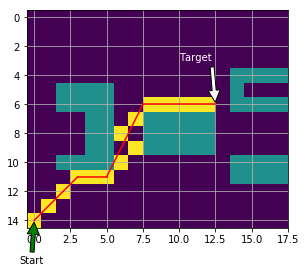

In [99]:
import matplotlib.pyplot as plt
plt.imshow(board.board)
plt.plot([0,3],[14,11],color='r')
plt.plot([3,5],[11,11],color='r')
plt.plot([5,7.5],[11,6],color='r')
plt.plot([7.5,12.5],[6,6],color='r')
plt.annotate('Start',(0,14),xytext =(-1, 17), arrowprops = dict(facecolor ='green',shrink = 0.05))
plt.annotate('Target',(12.5,6),xytext =(10, 3), color='white', arrowprops = dict(facecolor ='white',shrink = 0.05))
plt.grid()
plt.savefig('theta_star.png')